In [20]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mira.sources.sbml import template_model_from_sbml_file
import pyciemss
import pyciemss.visuals.plots as plots

# Path to the utils directory and add to path
script_path = os.path.abspath(os.path.join(os.pardir, os.pardir, 'utils'))
if script_path not in sys.path:
    sys.path.append(script_path)

# Load the autoreload extension
%load_ext autoreload
%autoreload 2

import community_modeling

# Get Python version
print(f"Python Version: {sys.version}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python Version: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:35:25) [Clang 16.0.6 ]


In [1]:
antimony_model_str = """
model MICP

  const water;

  // Reaction 1: Ureolysis
  reaction_ureolysis: urea + $water => 2 ammonia + carbon_dioxide; (V_max_urease*urea)/(K_m_urease + urea);  // Michaelis-Menton (water in excess and fixed);

  // Reaction 2: Protonation of Ammonia
  reaction_protonation_NH3: 2 ammonia + 2 water -> 2 ammonium + 2 hydroxide; k2f * ammonia^2 * water^2 - k2r * ammonium^2 * hydroxide^2;

  // Reaction 3: CO2 Hydrolysis
  reaction_CO2_hydrolysis: carbon_dioxide + water -> carbonic_acid; (K_cat_CA*CA_conc*carbon_dioxide)/(K_m_CA + carbon_dioxide);   // Michaelis-Menton;

  // Reaction 4: Dissociation of Carbonic Acid
  reaction_dissociation_H2CO3: carbonic_acid + hydroxide -> bicarbonate + water; k4f * carbonic_acid * hydroxide - k4r * bicarbonate * water;

  // Reaction 5: Dissociation of Bicarbonate
  reaction_dissociation_HCO3: bicarbonate + hydroxide -> carbonate + water; k5f * bicarbonate * hydroxide - k5r * carbonate * water;

  // Reaction 6: CaCO3 Precipitation/Dissolution
  reaction_CaCO3_precipitation: carbonate + calcium_ion -> calcium_carbonate; k6f * carbonate * calcium_ion - k6r * calcium_carbonate;

  // Set initial concentrations for species
  urea = 0.33;                      // Initial concentration for urea
  water = 55;                       // Initial concentration for water
  ammonia = 1e-5;                      // Initial concentration for ammonia
  carbon_dioxide = 1e-5;               // Initial concentration for carbon dioxide (from atmosphere)
  ammonium = 1e-5;                     // Initial concentration for ammonium
  hydroxide = 1e-7; // Initial concentration for hydroxide
  carbonic_acid = 1e-5;                // Initial concentration for carbonic acid
  bicarbonate = 1e-5;                  // Initial concentration for bicarbonate
  carbonate = 1e-5;                    // Initial concentration for carbonate
  calcium_ion = 0.136;                  // Initial concentration for calcium ion
  calcium_carbonate = 0;            // Initial concentration for calcium carbonate

  // Define rate constants
  k2f = 1;  // Rate constant for reaction 2 forward
  k2r = 1;  // Rate constant for reaction 2 reverse
  k4f = 1;  // Rate constant for reaction 4 forward
  k4r = 1;  // Rate constant for reaction 4 reverse  
  k5f = 1;  // Rate constant for reaction 5 forward
  k5r = 1;  // Rate constant for reaction 5 reverse 
  k6f = 1;  // Rate constant for reaction 6 forward
  k6r = 1;  // Rate constant for reaction 6 reverse

  // enyzematic reaction parameters
  V_max_urease = 1.8e4; // M/L/s (1100 mM/mg / min)
  K_m_urease= 0.3; // M (300 mM)
  K_cat_CA = 530000; // 1/s;
  CA_conc = 3e-5; // M/L (30 uM)
  K_m_CA = 12.9; // M (12900 mM) 

  //K_cat_urease = 1;
  //urease_conc = 5e-5; // M/L (50 uM)
  //V_max_CA = 1.8e6;

  // Define rate laws
  //rate_ureolysis :=  (V_max_urease*urea*water)/(K_m_urease + (urea*water));  // Michaelis-Menton
  //rate_protonation_NH3 := k2f * ammonia * water - k2r * ammonium * hydroxide;
  //rate_CO2_hydrolysis := (K_cat_CA*CA_conc*carbon_dioxide*water)/(K_m_CA + (carbon_dioxide*water));   // Michaelis-Menton
  //rate_dissociation_H2CO3 := k4f * carbonic_acid * hydroxide - k4r * bicarbonate * water;
  //rate_dissociation_HCO3 := k5f * bicarbonate * hydroxide - k5r * carbonate * water;
  //rate_CaCO3_precipitation := k6f * carbonate * calcium_ion - k6r * calcium_carbonate;

end
"""

In [2]:
sbml_file = 'microbial_induced_calcium_carbonate_precipitation_model.xml'
# antimony_fname = "microbial_induced_calcium_carbonate_precipitation_model.txt"
# sbml_file = 'microbial_induced_calcium_carbonate_precipitation_model.xml'
# # Write the Antimony model to a file
# with open(antimony_fname, "w") as f:
#     f.write(antimony_model_str)
# print(f"Antimony model written to {antimony_fname}")

# rr_model = te.loada(antimony_fname)
# rr_model.exportToSBML(sbml_file)

# print(f"SBML model written to {sbml_file}")

In [6]:
corrected_sbml_file = 'microbial_induced_calcium_carbonate_precipitation_model_corrected.xml'
#community_modeling.update_SBML_for_MIRA(original_sbml_file=sbml_file, updated_sbml_file=corrected_sbml_file)

In [12]:
mira_model = template_model_from_sbml_file(corrected_sbml_file)

In [15]:
mira_model = community_modeling.set_uniform_priors_for_MIRA_model_rate_constants(mira_model)
display(mira_model.parameters)
display(mira_model.initials)

{'V_max_urease': Parameter(name='V_max_urease', display_name=None, description='', identifiers={}, context={}, units=None, value=18000.0, distribution=None),
 'K_m_urease': Parameter(name='K_m_urease', display_name=None, description='', identifiers={}, context={}, units=None, value=0.3, distribution=None),
 'k2f': Parameter(name='k2f', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=Distribution(type='Uniform1', parameters={'minimum': 0.001, 'maximum': 1.0})),
 'k2r': Parameter(name='k2r', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=Distribution(type='Uniform1', parameters={'minimum': 0.001, 'maximum': 1.0})),
 'K_cat_CA': Parameter(name='K_cat_CA', display_name=None, description='', identifiers={}, context={}, units=None, value=530000.0, distribution=None),
 'CA_conc': Parameter(name='CA_conc', display_name=None, description='', identifiers={}, context={}, units=None, value=3e-05,

{'water': Initial(concept=Concept(name='water', display_name='water', description=None, identifiers={}, context={}, units=None), expression=55.0),
 'urea': Initial(concept=Concept(name='urea', display_name='urea', description=None, identifiers={}, context={}, units=None), expression=0.33),
 'ammonia': Initial(concept=Concept(name='ammonia', display_name='ammonia', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'carbon_dioxide': Initial(concept=Concept(name='carbon_dioxide', display_name='carbon_dioxide', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'ammonium': Initial(concept=Concept(name='ammonium', display_name='ammonium', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'hydroxide': Initial(concept=Concept(name='hydroxide', display_name='hydroxide', description=None, identifiers={}, context={}, units=None), expression=1.0e-7),
 'carbonic_acid': Initial(concept=Concept(name='carbonic_ac

In [16]:
model_json_file_name = 'microbial_induced_calcium_carbonate_precipitation_petri_net_model.json'
community_modeling.convert_MIRA_model_to_petrinet_AMRPetriNetModel(mira_model,model_json_file_name)

In [19]:
start_time = 0.0
end_time = 1.0
logging_step_size = 0.01
num_samples = 3

petrinet_results = pyciemss.sample(model_json_file_name, end_time, logging_step_size, num_samples, start_time=start_time)
display(petrinet_results['data'].head())
print(petrinet_results.keys())

,timepoint_id,sample_id,timepoint_unknown,persistent_k2f_param,persistent_k2r_param,persistent_k4f_param,persistent_k4r_param,persistent_k5f_param,persistent_k5r_param,persistent_k6f_param,...,ammonia_state,carbon_dioxide_state,water_state,ammonium_state,hydroxide_state,carbonic_acid_state,bicarbonate_state,carbonate_state,calcium_carbonate_state,calcium_ion_state
0,0,0,0.0,0.721776,0.445953,0.734296,0.837734,0.102727,0.926085,0.999716,...,0.000010,0.000010,55.000000,0.000010,1.000000e-07,0.000010,0.000010,1.000000e-05,0.000000e+00,0.136
1,1,0,0.01,0.721776,0.445953,0.734296,0.837734,0.102727,0.926085,0.999716,...,0.021920,0.326072,54.357971,0.308100,3.080924e-01,0.007881,0.000021,3.651291e-06,1.709272e-08,0.136
2,2,0,0.02,0.721776,0.445953,0.734296,0.837734,0.102727,0.926085,0.999716,...,0.011383,0.322175,54.343563,0.318637,3.186074e-01,0.015651,0.000047,1.347022e-06,2.329740e-08,0.136
3,3,0,0.03,0.721776,0.445953,0.734296,0.837734,0.102727,0.926085,0.999716,...,0.007731,0.318324,54.335976,0.322289,3.222262e-01,0.023321,0.000082,5.195379e-07,2.556172e-08,0.136
4,4,0,0.04,0.721776,0.445953,0.734296,0.837734,0.102727,0.926085,0.999716,...,0.005890,0.314517,54.330441,0.324129,3.240297e-01,0.030897,0.000119,2.330038e-07,2.642765e-08,0.136


dict_keys(['data', 'unprocessed_result', 'risk'])


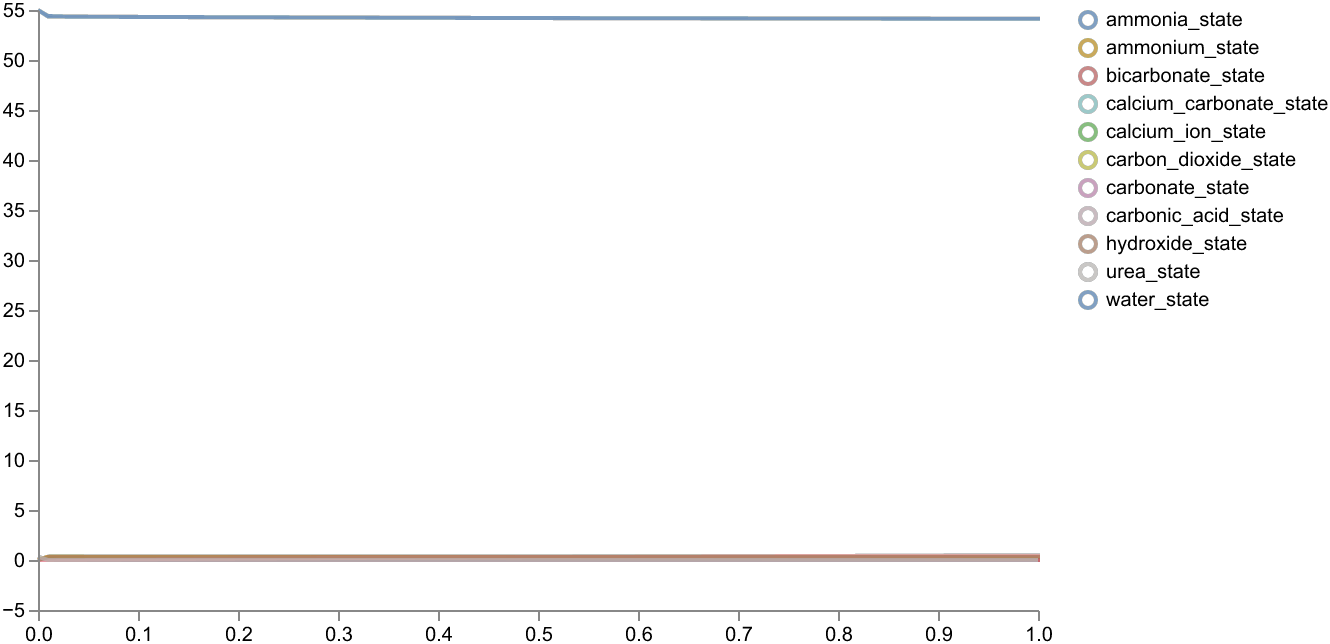

In [21]:
# Plot results for all states
schema = plots.trajectories(petrinet_results["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## FBA

need to set bounds on FBA model

In [24]:
import cobra
def optimize_calcium_carbonate_yield(sbml_file):
    # Load the SBML model
    model = cobra.io.read_sbml_model(sbml_file)
    
    # Set default bounds for all reactions
    for reaction in model.reactions:
        reaction.lower_bound = -1000
        reaction.upper_bound = 1000
    
    # Adjust bounds for specific reactions if needed
    model.reactions.get_by_id('reaction_ureolysis').lower_bound = 0   # Ureolysis is irreversible
    model.reactions.get_by_id('reaction_ureolysis').upper_bound = 1000  # Allow a large flux

    # Set the objective to maximize CaCO3 production
    model.objective = 'reaction_CaCO3_precipitation'
    model.reactions.get_by_id('reaction_CaCO3_precipitation').objective_coefficient = 1
    
    # Perform FBA
    solution = model.optimize()
    
    # Print the objective value (max yield of CaCO3)
    print("Objective value (CaCO3 yield):", solution.objective_value)
    
    # Print the flux distribution
    print("\nFlux distribution:")
    for reaction in model.reactions:
        print(f"{reaction.id}: {solution.fluxes[reaction.id]}")
    
    return solution
# Optimize for CaCO3 yield
solution = optimize_calcium_carbonate_yield(corrected_sbml_file)

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


Objective value (CaCO3 yield): 0.0

Flux distribution:
EX_water: 0.0
reaction_ureolysis: 0.0
reaction_protonation_NH3: 0.0
reaction_CO2_hydrolysis: 0.0
reaction_dissociation_H2CO3: 0.0
reaction_dissociation_HCO3: 0.0
reaction_CaCO3_precipitation: 0.0
